# 🎯 Parte 01: Entrenamiento de Quantile Mapping - RSDS

Este notebook implementa el **entrenamiento del modelo de Quantile Mapping** (DQM/EQM) para bias correction de RSDS (radiación solar) usando xclim.sdba.

## Objetivos:
1. Cargar datasets preparados de la Parte 00
2. Entrenar modelo DQM (Detrended Quantile Mapping)
3. Aplicar bias correction a historical completo
4. Validar la corrección contra observaciones
5. Guardar modelo entrenado para aplicar a SSPs
6. Generar reportes de validación

**Método**: Detrended Quantile Mapping (DQM) preserva tendencias de cambio climático  
**Fallback**: Empirical Quantile Mapping (EQM) si DQM falla  
**Agrupación**: Por mes del año (12 grupos) para capturar estacionalidad

---

**Inputs** (de Parte 00):
- `obs_rsds_prepared_2004-2014.nc` - Observaciones GHI mensuales
- `cmip6_rsds_prepared_2004-2014.nc` - CMIP6 historical preparado

**Outputs**:
- `qm_model_trained.zarr` - Modelo DQM/EQM entrenado
- `rsds_ACCESS-CM2_historical_bias_corrected.nc` - Historical corregido
- Gráficos de validación y reportes estadísticos

## 1️⃣ Imports y Configuración

In [1]:
# Imports principales
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import json

# xclim para bias correction
from xclim import sdba

# Dask para procesamiento paralelo
import dask
from dask.diagnostics import ProgressBar

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configuración de warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Configuración de Dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📦 xarray version: {xr.__version__}")
print(f"📦 xclim version: {sdba.__version__ if hasattr(sdba, '__version__') else 'instalado'}")

✅ Librerías importadas correctamente
📅 Fecha de ejecución: 2025-10-19 00:53:25
📦 xarray version: 2025.1.2
📦 xclim version: instalado


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xclim/sdba.py:12: UserWarning: The `xclim.sdba` module has been split into its own package `xsdba`. Users are encouraged to use `xsdba` directly. For the time being, `xclim.sdba` will import `xsdba` to allow for API compatibility. This behaviour may change in the future. For more information, see: https://xsdba.readthedocs.io/en/stable/xclim_migration_guide.html
  warnings.warn(


## 2️⃣ Definición de Rutas y Parámetros

In [2]:
# Rutas base del proyecto
BASE_DIR = Path('/home/aninotna/magister/tesis/justh2_pipeline')
SCRIPTS_DIR = BASE_DIR / 'scripts' / 'copernicus' / 'rsds'
OUTPUT_DIR = SCRIPTS_DIR / 'output'

# Rutas de datos preparados (Parte 00)
PREPARED_DIR = OUTPUT_DIR / 'prepared_data'
OBS_FILE = PREPARED_DIR / 'obs_rsds_prepared_2004-2014.nc'
HIST_FILE = PREPARED_DIR / 'cmip6_rsds_prepared_2004-2014.nc'

# Rutas de salida (Parte 01)
QM_DIR = OUTPUT_DIR / 'qm_models'
CORRECTED_DIR = OUTPUT_DIR / 'bias_corrected'
VALIDATION_DIR = OUTPUT_DIR / 'validation'

# Crear directorios si no existen
for directory in [QM_DIR, CORRECTED_DIR, VALIDATION_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Parámetros del Quantile Mapping
QM_PARAMS = {
    'nquantiles': 50,          # Número de cuantiles (más = más detalle, más lento)
    'group': 'time.month',     # Agrupar por mes del año
    'kind': '+',               # Tipo de tendencia: '+' aditivo (para temp/radiación)
    'extrapolation': 'constant' # Manejar valores fuera del rango de entrenamiento
}

# Verificar existencia de archivos de entrada
print("🔍 Verificando archivos de entrada (Parte 00)...")
print(f"   Obs preparadas: {'✅' if OBS_FILE.exists() else '❌'} {OBS_FILE}")
print(f"   CMIP6 preparado: {'✅' if HIST_FILE.exists() else '❌'} {HIST_FILE}")

if not (OBS_FILE.exists() and HIST_FILE.exists()):
    raise FileNotFoundError("❌ Archivos preparados no encontrados. Ejecuta primero el notebook Parte 00.")

print(f"\n📂 Directorios de salida:")
print(f"   Modelos QM: {QM_DIR}")
print(f"   Datos corregidos: {CORRECTED_DIR}")
print(f"   Validación: {VALIDATION_DIR}")

print(f"\n⚙️ Parámetros de Quantile Mapping:")
for key, val in QM_PARAMS.items():
    print(f"   {key}: {val}")

🔍 Verificando archivos de entrada (Parte 00)...
   Obs preparadas: ✅ /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/prepared_data/obs_rsds_prepared_2004-2014.nc
   CMIP6 preparado: ✅ /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/prepared_data/cmip6_rsds_prepared_2004-2014.nc

📂 Directorios de salida:
   Modelos QM: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/qm_models
   Datos corregidos: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/bias_corrected
   Validación: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/validation

⚙️ Parámetros de Quantile Mapping:
   nquantiles: 50
   group: time.month
   kind: +
   extrapolation: constant


## 3️⃣ Cargar Datos Preparados

In [3]:
print("📂 Cargando datos preparados de la Parte 00...")
print("=" * 70)

# Cargar observaciones
print("\n1️⃣ Cargando observaciones (GHI)...")
obs = xr.open_dataset(OBS_FILE)['rsds']
print(f"   ✅ Cargado: {obs.sizes}")
print(f"   Período: {pd.to_datetime(obs.time.values[0]).strftime('%Y-%m')} a {pd.to_datetime(obs.time.values[-1]).strftime('%Y-%m')}")
print(f"   Media: {float(obs.mean()):.2f} W/m²")
print(f"   % válidos: {100 - float(obs.isnull().mean() * 100):.2f}%")

# Cargar CMIP6 historical
print("\n2️⃣ Cargando CMIP6 historical preparado...")
hist = xr.open_dataset(HIST_FILE)['rsds']
print(f"   ✅ Cargado: {hist.sizes}")
print(f"   Período: {pd.to_datetime(hist.time.values[0]).strftime('%Y-%m')} a {pd.to_datetime(hist.time.values[-1]).strftime('%Y-%m')}")
print(f"   Media: {float(hist.mean()):.2f} W/m²")
print(f"   % válidos: {100 - float(hist.isnull().mean() * 100):.2f}%")

# Verificar coherencia
print("\n" + "=" * 70)
print("🔍 Verificación de coherencia:")
print("-" * 70)

checks = {
    "Misma grilla espacial": obs.sizes['lat'] == hist.sizes['lat'] and obs.sizes['lon'] == hist.sizes['lon'],
    "Mismo período temporal": len(obs.time) == len(hist.time),
    "Coordenadas idénticas (lat)": np.allclose(obs.lat.values, hist.lat.values, rtol=1e-5),
    "Coordenadas idénticas (lon)": np.allclose(obs.lon.values, hist.lon.values, rtol=1e-5),
    "Tiempo idéntico": np.array_equal(obs.time.values, hist.time.values),
    "Sin valores negativos (obs)": float(obs.min()) >= 0,
    "Sin valores negativos (hist)": float(hist.min()) >= 0,
}

all_ok = True
for check, result in checks.items():
    symbol = "✅" if result else "❌"
    print(f"{symbol} {check}")
    if not result:
        all_ok = False

if all_ok:
    print("\n" + "=" * 70)
    print("✅ Todos los checks pasaron. Datos listos para entrenamiento QM.")
    print("=" * 70)
else:
    raise ValueError("❌ Algunos checks fallaron. Revisa los datos preparados.")

📂 Cargando datos preparados de la Parte 00...

1️⃣ Cargando observaciones (GHI)...
   ✅ Cargado: Frozen({'time': 132, 'lat': 20, 'lon': 20})
   Período: 2004-01 a 2014-12
   Media: 225.47 W/m²
   % válidos: 82.50%

2️⃣ Cargando CMIP6 historical preparado...
   ✅ Cargado: Frozen({'time': 132, 'lat': 20, 'lon': 20})
   Período: 2004-01 a 2014-12
   Media: 243.51 W/m²
   % válidos: 82.50%

🔍 Verificación de coherencia:
----------------------------------------------------------------------
✅ Misma grilla espacial
✅ Mismo período temporal
✅ Coordenadas idénticas (lat)
✅ Coordenadas idénticas (lon)
✅ Tiempo idéntico
✅ Sin valores negativos (obs)
✅ Sin valores negativos (hist)

✅ Todos los checks pasaron. Datos listos para entrenamiento QM.


## 4️⃣ Entrenar Modelo de Quantile Mapping (DQM)

In [4]:
print("🎓 ENTRENAMIENTO DEL MODELO QUANTILE MAPPING")
print("=" * 70)

# Configurar agrupación
print(f"\n⚙️ Configuración:")
print(f"   Método: Detrended Quantile Mapping (DQM)")
print(f"   Agrupación: {QM_PARAMS['group']} (12 grupos estacionales)")
print(f"   Cuantiles: {QM_PARAMS['nquantiles']}")
print(f"   Tipo de tendencia: {QM_PARAMS['kind']} (aditivo)")

grouper = sdba.Grouper(QM_PARAMS['group'])

# Intentar entrenar DQM
print(f"\n🔄 Entrenando modelo DQM...")
print(f"   Esto puede tomar algunos minutos...")

try:
    start_time = datetime.now()
    
    with ProgressBar():
        QM = sdba.DetrendedQuantileMapping.train(
            ref=obs,              # Observaciones (referencia)
            hist=hist,            # CMIP6 historical (a corregir)
            nquantiles=QM_PARAMS['nquantiles'],
            group=grouper,
            kind=QM_PARAMS['kind']
        )
    
    training_time = (datetime.now() - start_time).total_seconds()
    method_used = 'DQM'
    
    print(f"\n   ✅ DQM entrenado exitosamente")
    print(f"   ⏱️ Tiempo de entrenamiento: {training_time:.1f} segundos")
    
except Exception as e:
    print(f"\n   ⚠️ DQM falló: {e}")
    print(f"   🔄 Intentando con EQM (Empirical Quantile Mapping)...")
    
    try:
        start_time = datetime.now()
        
        with ProgressBar():
            QM = sdba.EmpiricalQuantileMapping.train(
                ref=obs,
                hist=hist,
                nquantiles=QM_PARAMS['nquantiles'],
                group=grouper
            )
        
        training_time = (datetime.now() - start_time).total_seconds()
        method_used = 'EQM'
        
        print(f"\n   ✅ EQM entrenado exitosamente")
        print(f"   ⏱️ Tiempo de entrenamiento: {training_time:.1f} segundos")
        
    except Exception as e2:
        raise RuntimeError(f"❌ Ambos métodos fallaron. DQM: {e}, EQM: {e2}")

print(f"\n" + "=" * 70)
print(f"✅ MODELO {method_used} ENTRENADO EXITOSAMENTE")
print("=" * 70)

# Información del modelo
print(f"\n📊 Información del modelo:")
print(f"   Tipo: {type(QM).__name__}")
print(f"   Método: {method_used}")
print(f"   Entrenado en: {len(obs.time)} meses ({len(obs.time)/12:.1f} años)")
print(f"   Grupos: {len(grouper.group_dim) if hasattr(grouper, 'group_dim') else 12} (uno por mes)")
print(f"   Celdas espaciales: {int(obs.notnull().any('time').sum())} válidas")

🎓 ENTRENAMIENTO DEL MODELO QUANTILE MAPPING

⚙️ Configuración:
   Método: Detrended Quantile Mapping (DQM)
   Agrupación: time.month (12 grupos estacionales)
   Cuantiles: 50
   Tipo de tendencia: + (aditivo)

🔄 Entrenando modelo DQM...
   Esto puede tomar algunos minutos...

   ✅ DQM entrenado exitosamente
   ⏱️ Tiempo de entrenamiento: 3.8 segundos

✅ MODELO DQM ENTRENADO EXITOSAMENTE

📊 Información del modelo:
   Tipo: DetrendedQuantileMapping
   Método: DQM
   Entrenado en: 132 meses (11.0 años)
   Grupos: 12 (uno por mes)
   Celdas espaciales: 330 válidas


## 5️⃣ Aplicar Bias Correction a Historical

In [5]:
print("🔧 APLICANDO BIAS CORRECTION A HISTORICAL")
print("=" * 70)

print(f"\nAplicando corrección al período completo de calibración...")
print(f"   Dataset: CMIP6 historical (2004-2014)")
print(f"   Método: {method_used}")
print(f"   Extrapolación: {QM_PARAMS['extrapolation']}")

# Aplicar corrección
start_time = datetime.now()

with ProgressBar():
    hist_corrected = QM.adjust(
        sim=hist,
        extrapolation=QM_PARAMS['extrapolation']
    )

correction_time = (datetime.now() - start_time).total_seconds()

print(f"\n   ✅ Corrección aplicada")
print(f"   ⏱️ Tiempo: {correction_time:.1f} segundos")

# Asegurar no-negatividad (radiación no puede ser negativa)
print(f"\n🔍 Verificando no-negatividad...")
min_before = float(hist_corrected.min())
if min_before < 0:
    n_negative = int((hist_corrected < 0).sum())
    print(f"   ⚠️ Encontrados {n_negative} valores negativos (mín: {min_before:.2f} W/m²)")
    print(f"   🔧 Aplicando .clip(min=0)...")
    hist_corrected = hist_corrected.clip(min=0)
    print(f"   ✅ Valores negativos eliminados")
else:
    print(f"   ✅ Sin valores negativos (mín: {min_before:.2f} W/m²)")

# Añadir metadatos
hist_corrected.attrs['long_name'] = 'Bias-corrected Surface Downwelling Shortwave Radiation'
hist_corrected.attrs['units'] = 'W m-2'
hist_corrected.attrs['bias_correction_method'] = method_used
hist_corrected.attrs['bias_correction_period'] = '2004-2014'
hist_corrected.attrs['reference_data'] = 'GHI solar.minenergia.cl'
hist_corrected.attrs['source'] = 'CMIP6 ACCESS-CM2 historical'
hist_corrected.attrs['nquantiles'] = QM_PARAMS['nquantiles']
hist_corrected.attrs['grouping'] = QM_PARAMS['group']
hist_corrected.attrs['correction_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

print(f"\n📊 Estadísticas del historical corregido:")
print(f"   Media: {float(hist_corrected.mean()):.2f} W/m²")
print(f"   Desv. Est.: {float(hist_corrected.std()):.2f} W/m²")
print(f"   Mín: {float(hist_corrected.min()):.2f} W/m²")
print(f"   Máx: {float(hist_corrected.max()):.2f} W/m²")
print(f"   % válidos: {100 - float(hist_corrected.isnull().mean() * 100):.2f}%")

print("\n" + "=" * 70)
print("✅ BIAS CORRECTION APLICADO EXITOSAMENTE")
print("=" * 70)

🔧 APLICANDO BIAS CORRECTION A HISTORICAL

Aplicando corrección al período completo de calibración...
   Dataset: CMIP6 historical (2004-2014)
   Método: DQM
   Extrapolación: constant


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(



   ✅ Corrección aplicada
   ⏱️ Tiempo: 1.3 segundos

🔍 Verificando no-negatividad...
   ✅ Sin valores negativos (mín: 16.54 W/m²)

📊 Estadísticas del historical corregido:
   Media: 225.27 W/m²
   Desv. Est.: 103.95 W/m²
   Mín: 16.54 W/m²
   Máx: 428.09 W/m²
   % válidos: 82.50%

✅ BIAS CORRECTION APLICADO EXITOSAMENTE


## 6️⃣ Validación: Comparación Antes vs Después

In [6]:
print("📊 VALIDACIÓN: ANTES vs DESPUÉS DE BIAS CORRECTION")
print("=" * 70)

# Calcular promedios temporales
obs_mean = obs.mean(['lat', 'lon'])
hist_orig_mean = hist.mean(['lat', 'lon'])
hist_corr_mean = hist_corrected.mean(['lat', 'lon'])

# Estadísticas globales
print("\n1️⃣ ESTADÍSTICAS GLOBALES:")
print("-" * 70)
print(f"\n{'Dataset':<25} {'Media':<15} {'Desv.Est.':<15} {'Mín':<15} {'Máx':<15}")
print("-" * 70)
print(f"{'Observaciones (GHI)':<25} {float(obs.mean()):<15.2f} {float(obs.std()):<15.2f} {float(obs.min()):<15.2f} {float(obs.max()):<15.2f}")
print(f"{'CMIP6 Original':<25} {float(hist.mean()):<15.2f} {float(hist.std()):<15.2f} {float(hist.min()):<15.2f} {float(hist.max()):<15.2f}")
print(f"{'CMIP6 Corregido':<25} {float(hist_corrected.mean()):<15.2f} {float(hist_corrected.std()):<15.2f} {float(hist_corrected.min()):<15.2f} {float(hist_corrected.max()):<15.2f}")

# Sesgos
print("\n" + "=" * 70)
print("\n2️⃣ REDUCCIÓN DE SESGO:")
print("-" * 70)

bias_original = float(hist.mean() - obs.mean())
bias_corregido = float(hist_corrected.mean() - obs.mean())
reduccion_absoluta = bias_original - bias_corregido
reduccion_porcentual = 100 * (1 - abs(bias_corregido) / abs(bias_original)) if bias_original != 0 else 0

print(f"\n   Sesgo ORIGINAL (CMIP6 - OBS):    {bias_original:+.2f} W/m²")
print(f"   Sesgo CORREGIDO (CMIP6 - OBS):   {bias_corregido:+.2f} W/m²")
print(f"\n   📉 Reducción absoluta:           {reduccion_absoluta:.2f} W/m²")
print(f"   📉 Reducción porcentual:         {reduccion_porcentual:.1f}%")

# RMSE
print("\n" + "=" * 70)
print("\n3️⃣ ERROR CUADRÁTICO MEDIO (RMSE):")
print("-" * 70)

rmse_original = float(np.sqrt(((hist - obs)**2).mean()))
rmse_corregido = float(np.sqrt(((hist_corrected - obs)**2).mean()))
mejora_rmse = 100 * (1 - rmse_corregido / rmse_original)

print(f"\n   RMSE ORIGINAL:     {rmse_original:.2f} W/m²")
print(f"   RMSE CORREGIDO:    {rmse_corregido:.2f} W/m²")
print(f"\n   📉 Mejora:         {mejora_rmse:.1f}%")

# Correlación
print("\n" + "=" * 70)
print("\n4️⃣ CORRELACIÓN CON OBSERVACIONES:")
print("-" * 70)

corr_original = float(xr.corr(hist, obs))
corr_corregido = float(xr.corr(hist_corrected, obs))

print(f"\n   Correlación ORIGINAL:    {corr_original:.4f}")
print(f"   Correlación CORREGIDO:   {corr_corregido:.4f}")
print(f"\n   📈 Mejora:               {corr_corregido - corr_original:+.4f}")

print("\n" + "=" * 70)
print("✅ VALIDACIÓN COMPLETADA")
print("=" * 70)

📊 VALIDACIÓN: ANTES vs DESPUÉS DE BIAS CORRECTION

1️⃣ ESTADÍSTICAS GLOBALES:
----------------------------------------------------------------------

Dataset                   Media           Desv.Est.       Mín             Máx            
----------------------------------------------------------------------
Observaciones (GHI)       225.47          103.85          17.66           429.42         
CMIP6 Original            243.51          95.84           75.16           396.46         
CMIP6 Corregido           225.27          103.95          16.54           428.09         


2️⃣ REDUCCIÓN DE SESGO:
----------------------------------------------------------------------

   Sesgo ORIGINAL (CMIP6 - OBS):    +18.04 W/m²
   Sesgo CORREGIDO (CMIP6 - OBS):   -0.20 W/m²

   📉 Reducción absoluta:           18.23 W/m²
   📉 Reducción porcentual:         98.9%


3️⃣ ERROR CUADRÁTICO MEDIO (RMSE):
----------------------------------------------------------------------

   RMSE ORIGINAL:     35.77 W

## 7️⃣ Visualización: Series Temporales

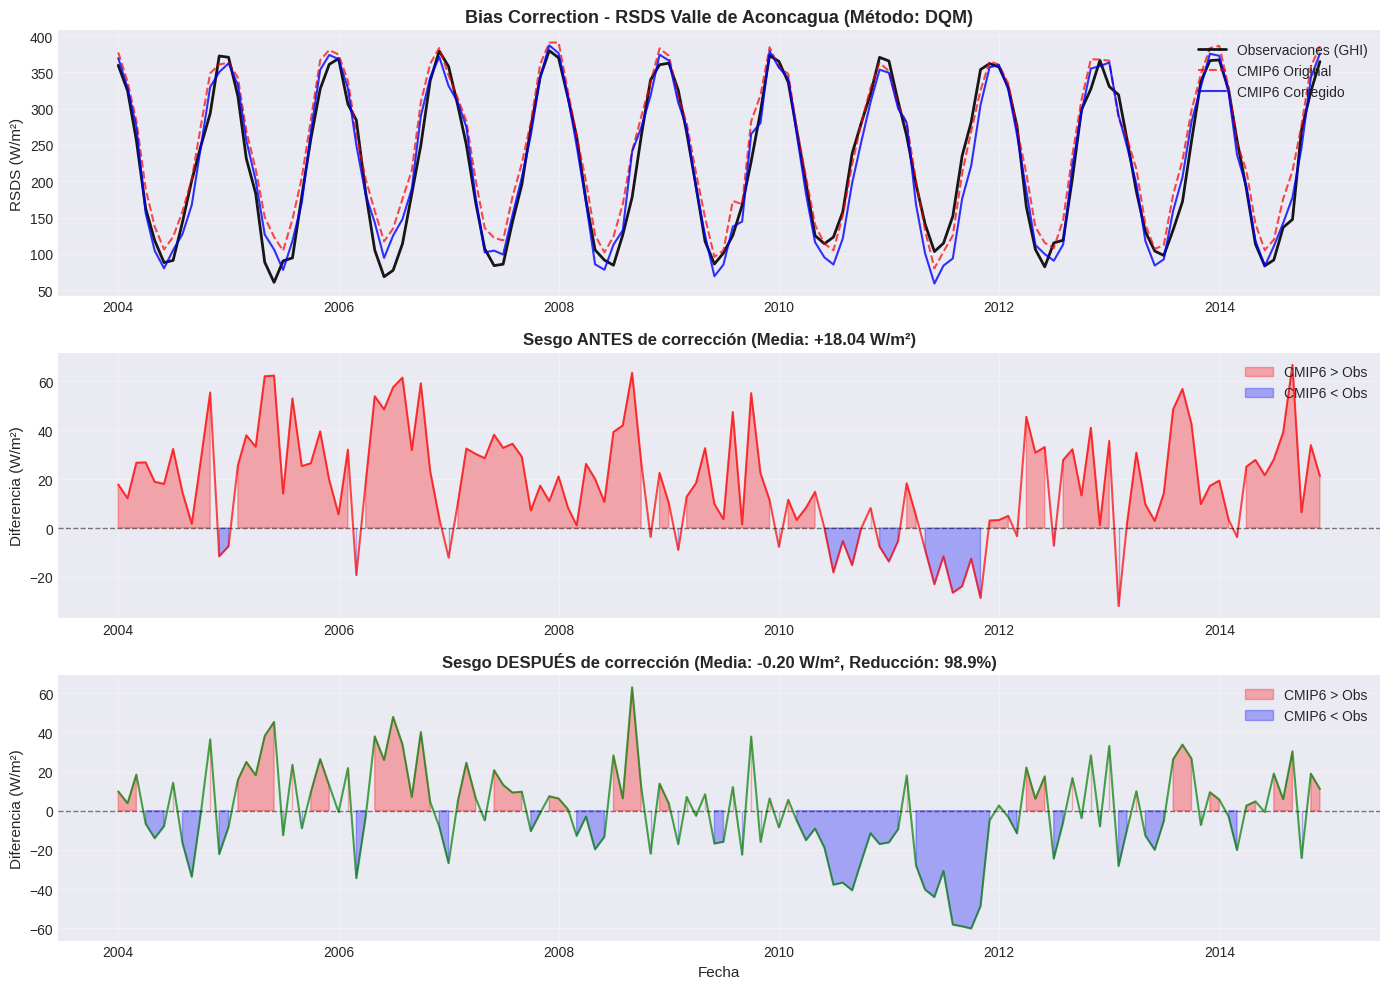

✅ Gráfico guardado: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/validation/bias_correction_series_temporales.png


In [7]:
# Gráfico de series temporales: Obs vs Original vs Corregido
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Panel 1: Comparación de series
ax1 = axes[0]
obs_mean.plot(ax=ax1, label='Observaciones (GHI)', color='black', lw=2, alpha=0.9)
hist_orig_mean.plot(ax=ax1, label='CMIP6 Original', color='red', lw=1.5, alpha=0.7, linestyle='--')
hist_corr_mean.plot(ax=ax1, label='CMIP6 Corregido', color='blue', lw=1.5, alpha=0.8)
ax1.set_title(f'Bias Correction - RSDS Valle de Aconcagua (Método: {method_used})', 
              fontsize=13, fontweight='bold')
ax1.set_ylabel('RSDS (W/m²)', fontsize=11)
ax1.set_xlabel('')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Panel 2: Sesgo antes de corrección
ax2 = axes[1]
diff_original = hist_orig_mean - obs_mean
diff_original.plot(ax=ax2, color='red', lw=1.5, alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', lw=1, alpha=0.5)
ax2.fill_between(diff_original.time.values, 0, diff_original.values,
                  where=(diff_original.values > 0), color='red', alpha=0.3, label='CMIP6 > Obs')
ax2.fill_between(diff_original.time.values, 0, diff_original.values,
                  where=(diff_original.values <= 0), color='blue', alpha=0.3, label='CMIP6 < Obs')
ax2.set_title(f'Sesgo ANTES de corrección (Media: {bias_original:+.2f} W/m²)', 
              fontsize=12, fontweight='bold')
ax2.set_ylabel('Diferencia (W/m²)', fontsize=11)
ax2.set_xlabel('')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: Sesgo después de corrección
ax3 = axes[2]
diff_corregido = hist_corr_mean - obs_mean
diff_corregido.plot(ax=ax3, color='green', lw=1.5, alpha=0.7)
ax3.axhline(0, color='black', linestyle='--', lw=1, alpha=0.5)
ax3.fill_between(diff_corregido.time.values, 0, diff_corregido.values,
                  where=(diff_corregido.values > 0), color='red', alpha=0.3, label='CMIP6 > Obs')
ax3.fill_between(diff_corregido.time.values, 0, diff_corregido.values,
                  where=(diff_corregido.values <= 0), color='blue', alpha=0.3, label='CMIP6 < Obs')
ax3.set_title(f'Sesgo DESPUÉS de corrección (Media: {bias_corregido:+.2f} W/m², Reducción: {reduccion_porcentual:.1f}%)', 
              fontsize=12, fontweight='bold')
ax3.set_ylabel('Diferencia (W/m²)', fontsize=11)
ax3.set_xlabel('Fecha', fontsize=11)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
output_file = VALIDATION_DIR / 'bias_correction_series_temporales.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado: {output_file}")

## 8️⃣ Guardar Modelo Entrenado

In [8]:
print("💾 GUARDANDO MODELO QUANTILE MAPPING ENTRENADO")
print("=" * 70)

# Guardar modelo como pickle (método estándar de xclim)
import pickle

model_file = QM_DIR / f'qm_model_{method_used.lower()}_trained_2004-2014.pkl'

print(f"\nGuardando modelo {method_used}...")
print(f"   Archivo: {model_file.name}")

with open(model_file, 'wb') as f:
    pickle.dump(QM, f)

size_mb = model_file.stat().st_size / (1024**2)
print(f"   ✅ Guardado ({size_mb:.2f} MB)")

# Guardar metadatos como JSON
metadata = {
    'model': 'ACCESS-CM2',
    'variable': 'rsds',
    'reference_data': 'GHI solar.minenergia.cl',
    'reference_period': '2004-01-01 to 2014-12-31',
    'method': method_used,
    'nquantiles': QM_PARAMS['nquantiles'],
    'grouping': QM_PARAMS['group'],
    'kind': QM_PARAMS['kind'],
    'extrapolation': QM_PARAMS['extrapolation'],
    'training_duration_months': len(obs.time),
    'training_duration_years': float(len(obs.time) / 12),
    'training_time_seconds': training_time,
    'region': 'Valle de Aconcagua, Chile',
    'lat_range': [float(obs.lat.min()), float(obs.lat.max())],
    'lon_range': [float(obs.lon.min()), float(obs.lon.max())],
    'spatial_cells_valid': int(obs.notnull().any('time').sum()),
    'spatial_cells_total': obs.sizes['lat'] * obs.sizes['lon'],
    'bias_original_Wm2': float(bias_original),
    'bias_corrected_Wm2': float(bias_corregido),
    'bias_reduction_percent': float(reduccion_porcentual),
    'rmse_original_Wm2': float(rmse_original),
    'rmse_corrected_Wm2': float(rmse_corregido),
    'rmse_improvement_percent': float(mejora_rmse),
    'correlation_original': float(corr_original),
    'correlation_corrected': float(corr_corregido),
    'date_created': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'created_by': '01_entrenamiento_quantile_mapping.ipynb'
}

metadata_file = QM_DIR / f'qm_model_{method_used.lower()}_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nMetadatos guardados:")
print(f"   Archivo: {metadata_file.name}")

print("\n" + "=" * 70)
print("✅ MODELO Y METADATOS GUARDADOS")
print("=" * 70)
print(f"\n📂 Ubicación: {QM_DIR}")
print(f"   - {model_file.name}")
print(f"   - {metadata_file.name}")

💾 GUARDANDO MODELO QUANTILE MAPPING ENTRENADO

Guardando modelo DQM...
   Archivo: qm_model_dqm_trained_2004-2014.pkl
   ✅ Guardado (0.00 MB)

Metadatos guardados:
   Archivo: qm_model_dqm_metadata.json

✅ MODELO Y METADATOS GUARDADOS

📂 Ubicación: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/qm_models
   - qm_model_dqm_trained_2004-2014.pkl
   - qm_model_dqm_metadata.json


## 9️⃣ Guardar Historical Corregido

In [10]:
print("💾 GUARDANDO HISTORICAL BIAS-CORRECTED")
print("=" * 70)

output_file = CORRECTED_DIR / 'rsds_ACCESS-CM2_historical_bias_corrected_2004-2014.nc'

print(f"\nGuardando archivo NetCDF...")
print(f"   Archivo: {output_file.name}")

# Convertir DataArray a Dataset
ds_to_save = hist_corrected.to_dataset(name='rsds')

# Configuración de encoding
encoding = {
    'rsds': {
        'dtype': 'float32',
        '_FillValue': -9999.0,
        'zlib': True,
        'complevel': 4
    }
}

# Guardar
with ProgressBar():
    ds_to_save.to_netcdf(output_file, encoding=encoding)

size_mb = output_file.stat().st_size / (1024**2)
print(f"   ✅ Guardado ({size_mb:.2f} MB)")

print("\n" + "=" * 70)
print("✅ HISTORICAL CORREGIDO GUARDADO")
print("=" * 70)
print(f"\n📂 Ubicación: {output_file}")

💾 GUARDANDO HISTORICAL BIAS-CORRECTED

Guardando archivo NetCDF...
   Archivo: rsds_ACCESS-CM2_historical_bias_corrected_2004-2014.nc
   ✅ Guardado (0.14 MB)

✅ HISTORICAL CORREGIDO GUARDADO

📂 Ubicación: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/bias_corrected/rsds_ACCESS-CM2_historical_bias_corrected_2004-2014.nc


## 🔟 Reporte Final

## 🔟 Validación Espacial: Mapas Comparativos

🗺️ VALIDACIÓN ESPACIAL: MAPAS COMPARATIVOS

Calculando medias temporales...


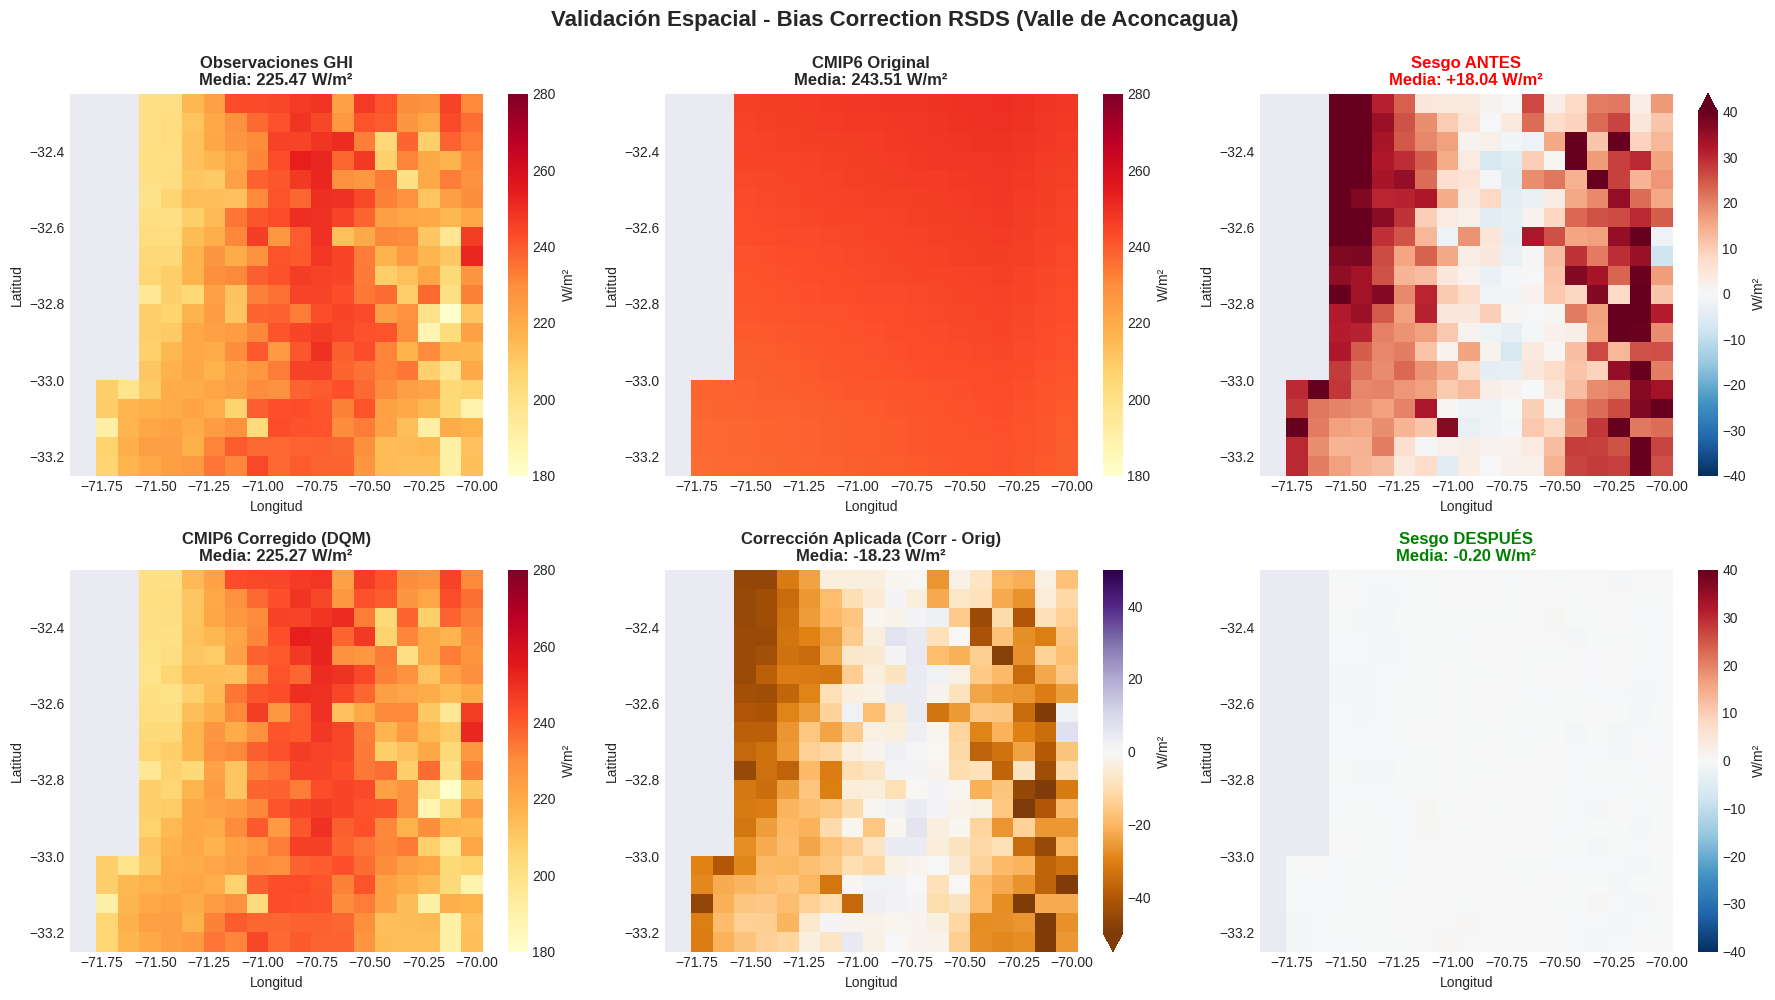


✅ Gráfico guardado: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/validation/bias_correction_mapas_espaciales.png


In [14]:
print("🗺️ VALIDACIÓN ESPACIAL: MAPAS COMPARATIVOS")
print("=" * 70)

# Calcular medias temporales para visualización espacial
print("\nCalculando medias temporales...")
obs_spatial = obs.mean('time')
hist_orig_spatial = hist.mean('time')
hist_corr_spatial = hist_corrected.mean('time')

# Calcular sesgos espaciales
bias_orig_spatial = hist_orig_spatial - obs_spatial
bias_corr_spatial = hist_corr_spatial - obs_spatial

# Crear figura con 6 paneles (2 filas x 3 columnas)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), 
                         subplot_kw={'projection': None})

# Parámetros comunes para mapas de RSDS
vmin_rsds, vmax_rsds = 180, 280
cmap_rsds = 'YlOrRd'

# Parámetros para mapas de sesgo
vmin_bias, vmax_bias = -40, 40
cmap_bias = 'RdBu_r'

# ========== FILA 1: DATOS ORIGINALES ==========
# Panel 1: Observaciones
ax1 = axes[0, 0]
im1 = obs_spatial.plot(ax=ax1, x='lon', y='lat', cmap=cmap_rsds, vmin=vmin_rsds, vmax=vmax_rsds,
                        add_colorbar=True, cbar_kwargs={'label': 'W/m²'})
ax1.set_title(f'Observaciones GHI\nMedia: {float(obs_spatial.mean()):.2f} W/m²', 
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Longitud')
ax1.set_ylabel('Latitud')

# Panel 2: CMIP6 Original
ax2 = axes[0, 1]
im2 = hist_orig_spatial.plot(ax=ax2, x='lon', y='lat', cmap=cmap_rsds, vmin=vmin_rsds, vmax=vmax_rsds,
                              add_colorbar=True, cbar_kwargs={'label': 'W/m²'})
ax2.set_title(f'CMIP6 Original\nMedia: {float(hist_orig_spatial.mean()):.2f} W/m²', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Longitud')
ax2.set_ylabel('Latitud')

# Panel 3: Sesgo Original
ax3 = axes[0, 2]
im3 = bias_orig_spatial.plot(ax=ax3, x='lon', y='lat', cmap=cmap_bias, vmin=vmin_bias, vmax=vmax_bias,
                              add_colorbar=True, cbar_kwargs={'label': 'W/m²'},
                              center=0)
ax3.set_title(f'Sesgo ANTES\nMedia: {float(bias_orig_spatial.mean()):+.2f} W/m²', 
              fontsize=12, fontweight='bold', color='red')
ax3.set_xlabel('Longitud')
ax3.set_ylabel('Latitud')

# ========== FILA 2: DATOS CORREGIDOS ==========
# Panel 4: CMIP6 Corregido
ax4 = axes[1, 0]
im4 = hist_corr_spatial.plot(ax=ax4, x='lon', y='lat', cmap=cmap_rsds, vmin=vmin_rsds, vmax=vmax_rsds,
                              add_colorbar=True, cbar_kwargs={'label': 'W/m²'})
ax4.set_title(f'CMIP6 Corregido (DQM)\nMedia: {float(hist_corr_spatial.mean()):.2f} W/m²', 
              fontsize=12, fontweight='bold')
ax4.set_xlabel('Longitud')
ax4.set_ylabel('Latitud')

# Panel 5: Diferencia CMIP6 Corregido vs Original
ax5 = axes[1, 1]
diff_correction = hist_corr_spatial - hist_orig_spatial
im5 = diff_correction.plot(ax=ax5, x='lon', y='lat', cmap='PuOr', vmin=-50, vmax=50,
                            add_colorbar=True, cbar_kwargs={'label': 'W/m²'},
                            center=0)
ax5.set_title(f'Corrección Aplicada (Corr - Orig)\nMedia: {float(diff_correction.mean()):+.2f} W/m²', 
              fontsize=12, fontweight='bold')
ax5.set_xlabel('Longitud')
ax5.set_ylabel('Latitud')

# Panel 6: Sesgo Corregido
ax6 = axes[1, 2]
im6 = bias_corr_spatial.plot(ax=ax6, x='lon', y='lat', cmap=cmap_bias, vmin=vmin_bias, vmax=vmax_bias,
                              add_colorbar=True, cbar_kwargs={'label': 'W/m²'},
                              center=0)
ax6.set_title(f'Sesgo DESPUÉS\nMedia: {float(bias_corr_spatial.mean()):+.2f} W/m²', 
              fontsize=12, fontweight='bold', color='green')
ax6.set_xlabel('Longitud')
ax6.set_ylabel('Latitud')

# Título general
fig.suptitle('Validación Espacial - Bias Correction RSDS (Valle de Aconcagua)', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
output_file = VALIDATION_DIR / 'bias_correction_mapas_espaciales.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráfico guardado: {output_file}")

In [13]:
print("📊 ESTADÍSTICAS ESPACIALES DETALLADAS")
print("=" * 70)

# Análisis por celda (solo celdas válidas)
valid_mask = obs_spatial.notnull()
n_valid = int(valid_mask.sum())

print(f"\n🗺️ Celdas válidas: {n_valid} de {obs_spatial.size}")
print(f"   Porcentaje: {100*n_valid/obs_spatial.size:.1f}%")

# Estadísticas del sesgo espacial
print("\n" + "=" * 70)
print("1️⃣ DISTRIBUCIÓN ESPACIAL DEL SESGO ORIGINAL:")
print("-" * 70)
bias_orig_valid = bias_orig_spatial.where(valid_mask)
print(f"   Media:          {float(bias_orig_valid.mean()):+.2f} W/m²")
print(f"   Desv. Est.:     {float(bias_orig_valid.std()):.2f} W/m²")
print(f"   Mínimo:         {float(bias_orig_valid.min()):+.2f} W/m²")
print(f"   Máximo:         {float(bias_orig_valid.max()):+.2f} W/m²")
print(f"   P25:            {float(bias_orig_valid.quantile(0.25)):+.2f} W/m²")
print(f"   Mediana (P50):  {float(bias_orig_valid.median()):+.2f} W/m²")
print(f"   P75:            {float(bias_orig_valid.quantile(0.75)):+.2f} W/m²")

# Celdas con sobreestimación/subestimación
n_over = int((bias_orig_valid > 0).sum())
n_under = int((bias_orig_valid < 0).sum())
print(f"\n   Celdas sobreestimadas (>0):  {n_over} ({100*n_over/n_valid:.1f}%)")
print(f"   Celdas subestimadas (<0):    {n_under} ({100*n_under/n_valid:.1f}%)")

print("\n" + "=" * 70)
print("2️⃣ DISTRIBUCIÓN ESPACIAL DEL SESGO CORREGIDO:")
print("-" * 70)
bias_corr_valid = bias_corr_spatial.where(valid_mask)
print(f"   Media:          {float(bias_corr_valid.mean()):+.2f} W/m²")
print(f"   Desv. Est.:     {float(bias_corr_valid.std()):.2f} W/m²")
print(f"   Mínimo:         {float(bias_corr_valid.min()):+.2f} W/m²")
print(f"   Máximo:         {float(bias_corr_valid.max()):+.2f} W/m²")
print(f"   P25:            {float(bias_corr_valid.quantile(0.25)):+.2f} W/m²")
print(f"   Mediana (P50):  {float(bias_corr_valid.median()):+.2f} W/m²")
print(f"   P75:            {float(bias_corr_valid.quantile(0.75)):+.2f} W/m²")

# Celdas con sobreestimación/subestimación
n_over_corr = int((bias_corr_valid > 0).sum())
n_under_corr = int((bias_corr_valid < 0).sum())
print(f"\n   Celdas sobreestimadas (>0):  {n_over_corr} ({100*n_over_corr/n_valid:.1f}%)")
print(f"   Celdas subestimadas (<0):    {n_under_corr} ({100*n_under_corr/n_valid:.1f}%)")

print("\n" + "=" * 70)
print("3️⃣ MEJORA ESPACIAL:")
print("-" * 70)

# Reducción de sesgo absoluto por celda
abs_bias_orig = np.abs(bias_orig_valid)
abs_bias_corr = np.abs(bias_corr_valid)
mejora_espacial = abs_bias_orig - abs_bias_corr

print(f"   Sesgo absoluto medio ANTES:   {float(abs_bias_orig.mean()):.2f} W/m²")
print(f"   Sesgo absoluto medio DESPUÉS: {float(abs_bias_corr.mean()):.2f} W/m²")
print(f"   Reducción media:              {float(mejora_espacial.mean()):.2f} W/m²")
print(f"   Reducción porcentual:         {100*float(mejora_espacial.mean()/abs_bias_orig.mean()):.1f}%")

# Celdas mejoradas vs empeoradas
n_mejora = int((mejora_espacial > 0).sum())
n_empeora = int((mejora_espacial < 0).sum())
print(f"\n   Celdas mejoradas:   {n_mejora} ({100*n_mejora/n_valid:.1f}%)")
print(f"   Celdas empeoradas:  {n_empeora} ({100*n_empeora/n_valid:.1f}%)")

# Variabilidad espacial
print("\n" + "=" * 70)
print("4️⃣ VARIABILIDAD ESPACIAL:")
print("-" * 70)
print(f"   Desv.Est. sesgo ANTES:   {float(bias_orig_valid.std()):.2f} W/m²")
print(f"   Desv.Est. sesgo DESPUÉS: {float(bias_corr_valid.std()):.2f} W/m²")
cambio_variabilidad = float(bias_corr_valid.std()) - float(bias_orig_valid.std())
print(f"   Cambio:                  {cambio_variabilidad:+.2f} W/m²")
if cambio_variabilidad < 0:
    print(f"   ✅ Sesgo más homogéneo (menor variabilidad espacial)")
else:
    print(f"   ⚠️ Sesgo menos homogéneo (mayor variabilidad espacial)")

print("\n" + "=" * 70)
print("✅ ANÁLISIS ESPACIAL COMPLETADO")
print("=" * 70)

📊 ESTADÍSTICAS ESPACIALES DETALLADAS

🗺️ Celdas válidas: 330 de 400
   Porcentaje: 82.5%

1️⃣ DISTRIBUCIÓN ESPACIAL DEL SESGO ORIGINAL:
----------------------------------------------------------------------
   Media:          +18.04 W/m²
   Desv. Est.:     14.70 W/m²
   Mínimo:         -8.10 W/m²
   Máximo:         +62.95 W/m²
   P25:            +4.18 W/m²
   Mediana (P50):  +16.89 W/m²
   P75:            +28.57 W/m²

   Celdas sobreestimadas (>0):  294 (89.1%)
   Celdas subestimadas (<0):    36 (10.9%)

2️⃣ DISTRIBUCIÓN ESPACIAL DEL SESGO CORREGIDO:
----------------------------------------------------------------------
   Media:          -0.20 W/m²
   Desv. Est.:     0.29 W/m²
   Mínimo:         -0.88 W/m²
   Máximo:         +0.42 W/m²
   P25:            -0.41 W/m²
   Mediana (P50):  -0.20 W/m²
   P75:            +0.06 W/m²

   Celdas sobreestimadas (>0):  106 (32.1%)
   Celdas subestimadas (<0):    224 (67.9%)

3️⃣ MEJORA ESPACIAL:
----------------------------------------------------

In [11]:
print("=" * 80)
print(" " * 20 + "📋 REPORTE FINAL - PARTE 01")
print("=" * 80)

print("\n✅ ENTRENAMIENTO COMPLETADO:")
print("-" * 80)
print(f"   Método utilizado: {method_used}")
print(f"   Tiempo de entrenamiento: {training_time:.1f} segundos")
print(f"   Período de entrenamiento: 2004-2014 ({len(obs.time)} meses)")
print(f"   Celdas válidas: {int(obs.notnull().any('time').sum())} de {obs.sizes['lat']*obs.sizes['lon']}")

print("\n📊 MÉTRICAS DE VALIDACIÓN:")
print("-" * 80)
print(f"\n   Sesgo (CMIP6 - OBS):")
print(f"      ANTES:     {bias_original:+.2f} W/m²")
print(f"      DESPUÉS:   {bias_corregido:+.2f} W/m²")
print(f"      Reducción: {reduccion_porcentual:.1f}%")

print(f"\n   RMSE:")
print(f"      ANTES:     {rmse_original:.2f} W/m²")
print(f"      DESPUÉS:   {rmse_corregido:.2f} W/m²")
print(f"      Mejora:    {mejora_rmse:.1f}%")

print(f"\n   Correlación:")
print(f"      ANTES:     {corr_original:.4f}")
print(f"      DESPUÉS:   {corr_corregido:.4f}")
print(f"      Mejora:    {corr_corregido - corr_original:+.4f}")

print("\n📁 ARCHIVOS GENERADOS:")
print("-" * 80)
print(f"\n   Modelo entrenado:")
print(f"   📄 {model_file}")
print(f"   📄 {metadata_file}")

print(f"\n   Historical corregido:")
print(f"   📄 {output_file}")

print(f"\n   Visualizaciones:")
print(f"   📊 {VALIDATION_DIR / 'bias_correction_series_temporales.png'}")

print("\n" + "=" * 80)
print("\n🎯 PRÓXIMO PASO: Aplicar el modelo a escenarios SSP")
print("-" * 80)
print("""
El modelo entrenado está listo para aplicarse a:
   - SSP245 (2015-2100)
   - SSP370 (2015-2100)
   - SSP585 (2015-2100)

Usando el MISMO modelo QM entrenado, preservando las diferencias entre escenarios.
""")

print("=" * 80)
print("\n✅ PARTE 01 COMPLETADA EXITOSAMENTE")
print("=" * 80)

                    📋 REPORTE FINAL - PARTE 01

✅ ENTRENAMIENTO COMPLETADO:
--------------------------------------------------------------------------------
   Método utilizado: DQM
   Tiempo de entrenamiento: 3.8 segundos
   Período de entrenamiento: 2004-2014 (132 meses)
   Celdas válidas: 330 de 400

📊 MÉTRICAS DE VALIDACIÓN:
--------------------------------------------------------------------------------

   Sesgo (CMIP6 - OBS):
      ANTES:     +18.04 W/m²
      DESPUÉS:   -0.20 W/m²
      Reducción: 98.9%

   RMSE:
      ANTES:     35.77 W/m²
      DESPUÉS:   26.13 W/m²
      Mejora:    27.0%

   Correlación:
      ANTES:     0.9553
      DESPUÉS:   0.9684
      Mejora:    +0.0131

📁 ARCHIVOS GENERADOS:
--------------------------------------------------------------------------------

   Modelo entrenado:
   📄 /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/qm_models/qm_model_dqm_trained_2004-2014.pkl
   📄 /home/aninotna/magister/tesis/justh2_pipeline/